先对单个音频进行预处理

开始处理文件: ./data1-4/1/01.wav
=== 开始调试 ===
文件: 01.wav
采样率: 16000Hz
时长: 30.67秒
通道数: 1
最大幅值: 0.6655


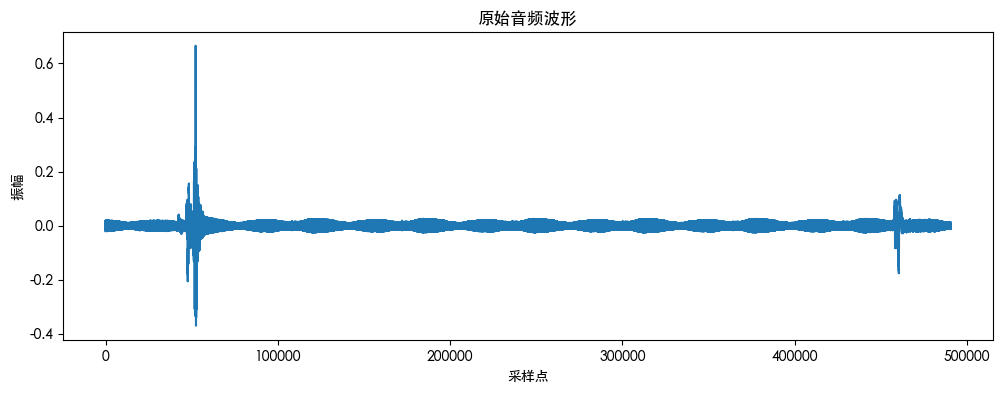

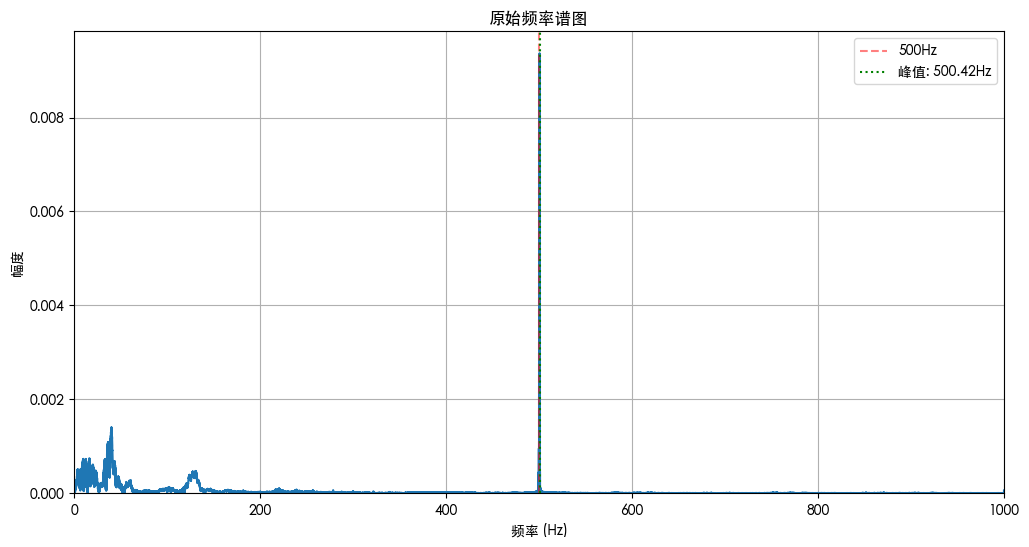

主要频率成分: 500.42Hz

=== 裁剪音频 ===
裁剪后时长: 22.67秒


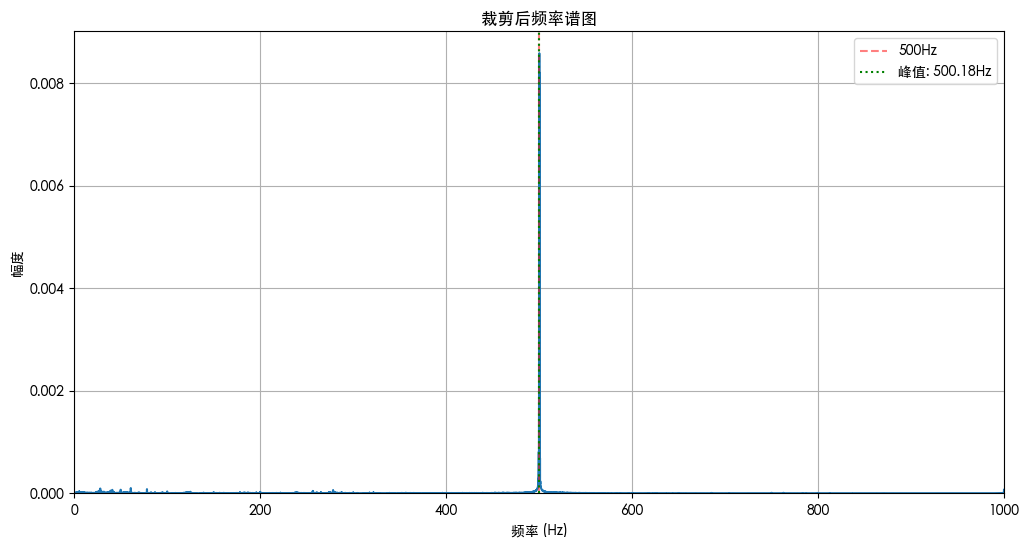


=== 滤波器设计 ===


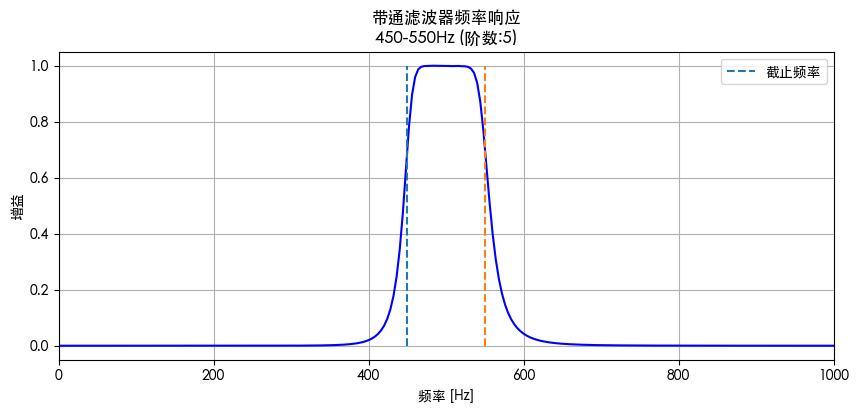


=== 应用滤波器 ===

=== 结果对比 ===


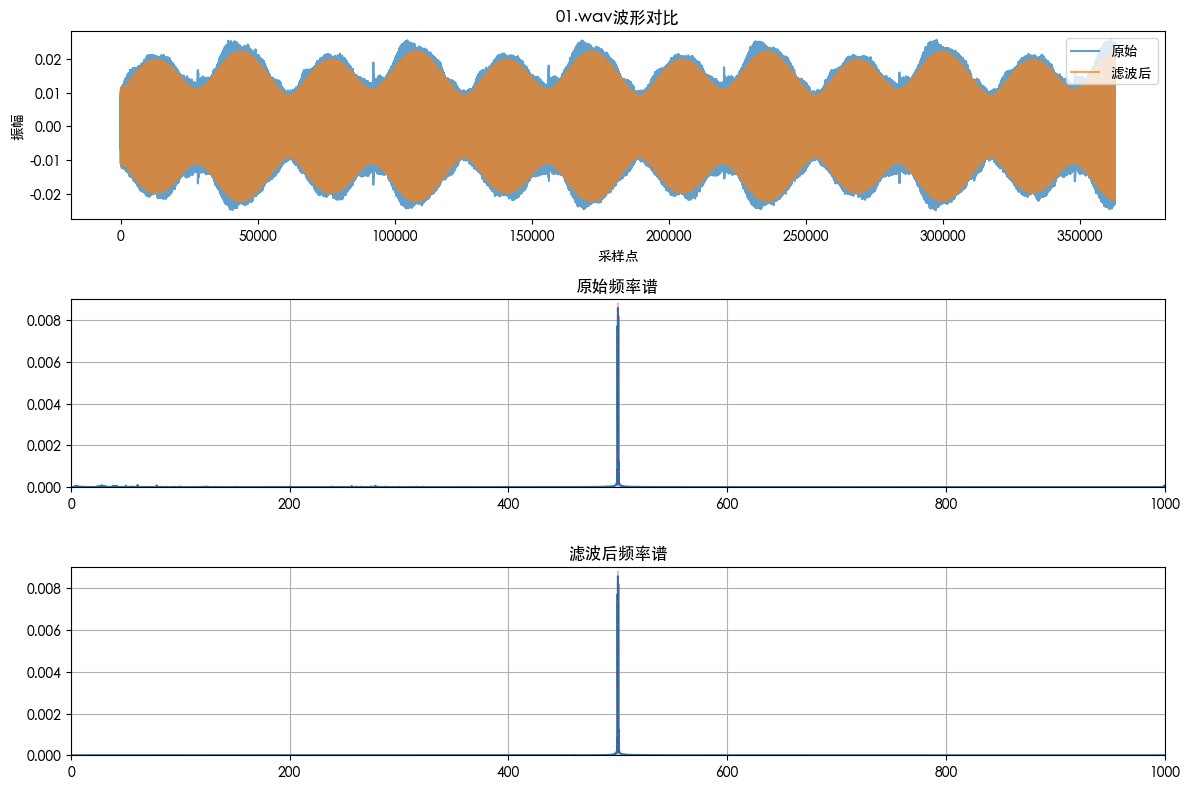


结果已保存到: ./data1-4/1/processed/filtered_01.wav

=== 处理成功 ===


In [ ]:
import os
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz
from scipy.fft import fft, fftfreq
from matplotlib import font_manager

# ==================== 中文字体设置 ====================
def set_chinese_font():
    
    try:
        # 尝试自动检测可用中文字体
        font_path = None
        
        # 常见中文字体路径
        possible_fonts = [
            # Windows
            'C:/Windows/Fonts/simhei.ttf',  
            'C:/Windows/Fonts/msyh.ttc',    
            
            # Mac
            '/System/Library/Fonts/PingFang.ttc',
            '/System/Library/Fonts/STHeiti Medium.ttc',
            
            # Linux
            '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc',
            '/usr/share/fonts/truetype/wqy/wqy-microhei.ttc'
        ]
        
        # 检查字体是否存在
        for font in possible_fonts:
            if os.path.exists(font):
                font_path = font
                break
        
        if font_path:
            # 动态添加字体
            font_manager.fontManager.addfont(font_path)
            prop = font_manager.FontProperties(fname=font_path)
            plt.rcParams['font.family'] = prop.get_name()
        else:
            # 尝试使用系统已有字体
            try:
                if os.name == 'nt':  # Windows
                    plt.rcParams['font.sans-serif'] = ['SimHei']
                else:  # Mac/Linux
                    for font in ['Arial Unicode MS', 'PingFang SC', 'Noto Sans CJK SC']:
                        if font in [f.name for f in font_manager.fontManager.ttflist]:
                            plt.rcParams['font.sans-serif'] = [font]
                            break
            except:
                print("警告: 无法设置中文字体，将使用默认字体")
        
        plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
        return True
    
    except Exception as e:
        print(f"设置中文字体时出错: {str(e)}")
        return False

# 初始化中文字体
set_chinese_font()

# ==================== 音频处理函数 ====================
def load_and_inspect(filepath):
    """加载音频文件并察看基本信息"""
    waveform, sample_rate = torchaudio.load(filepath)
    print(f"文件: {os.path.basename(filepath)}")
    print(f"采样率: {sample_rate}Hz")
    print(f"时长: {waveform.shape[1]/sample_rate:.2f}秒")
    print(f"通道数: {waveform.shape[0]}")
    print(f"最大幅值: {torch.max(torch.abs(waveform)).item():.4f}")
    
    # 绘制原始波形
    plt.figure(figsize=(12, 4))
    plt.plot(waveform[0].numpy())
    plt.title("原始音频波形")
    plt.xlabel("采样点")
    plt.ylabel("振幅")
    plt.show()
    
    return waveform, sample_rate

def plot_original_spectrum(waveform, sample_rate, title="频率谱图"):
    """
    绘制原始频率谱图（Hz为单位的真实频率）
    
    参数:
        waveform: 音频波形数据 (torch.Tensor, shape: [channels, samples])
        sample_rate: 采样率 (Hz)
        title: 图表标题
    """
    # 转换为单通道numpy数组
    if isinstance(waveform, torch.Tensor):
        waveform = waveform.numpy()
    y = waveform[0] if len(waveform.shape) > 1 else waveform
    
    # 计算FFT
    N = len(y)
    yf = fft(y)
    xf = fftfreq(N, 1/sample_rate)[:N//2]  # 获取真实频率坐标
    
    # 计算幅度谱 
    magnitude = np.abs(yf[:N//2]) / N
    magnitude[1:] *= 2  # 除DC分量外其他分量乘以2
    
    # 绘制频谱图
    plt.figure(figsize=(12, 6))
    plt.plot(xf, magnitude)
    plt.axvline(500, color='r', linestyle='--', alpha=0.5, label='500Hz')
    
    # 标记峰值频率
    peak_idx = np.argmax(magnitude)
    peak_freq = xf[peak_idx]
    plt.axvline(peak_freq, color='g', linestyle=':', 
                label=f'峰值: {peak_freq:.2f}Hz')
    
    plt.xlim(0, 1000)  # 聚焦0-1000Hz范围
    plt.ylim(bottom=0)
    plt.title(title)
    plt.xlabel("频率 (Hz)")
    plt.ylabel("幅度")
    plt.legend()
    plt.grid()
    plt.show()
    
    return peak_freq

def design_filter(sample_rate, lowcut=450, highcut=550, order=5):
    """设计和可视化滤波器"""
    # 设计滤波器
    nyq = 0.5 * sample_rate
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    
    # 绘制频率响应
    w, h = freqz(b, a, worN=2000)
    plt.figure(figsize=(10, 4))
    plt.plot(0.5*sample_rate*w/np.pi, np.abs(h), 'b')
    plt.plot([lowcut, lowcut], [0, 1], '--', label='截止频率')
    plt.plot([highcut, highcut], [0, 1], '--')
    plt.xlim(0, 1000)
    plt.title(f"带通滤波器频率响应\n{lowcut}-{highcut}Hz (阶数:{order})")
    plt.xlabel('频率 [Hz]')
    plt.ylabel('增益')
    plt.grid()
    plt.legend()
    plt.show()
    
    return b, a

def apply_filter_safe(waveform, sample_rate, b, a):
    """安全的滤波应用方法"""
    if isinstance(waveform, torch.Tensor):
        waveform = waveform.numpy()
    
    if len(waveform.shape) > 1:
        waveform = waveform[0]
    
    filtered = lfilter(b, a, waveform)
    
    return torch.from_numpy(filtered).float().unsqueeze(0)

def compare_results(original, filtered, sample_rate, title=""):
    """对比原始和滤波后的结果"""
    plt.figure(figsize=(12, 8))
    
    # 波形对比
    plt.subplot(3, 1, 1)
    plt.plot(original[0].numpy(), alpha=0.7, label='原始')
    plt.plot(filtered[0].numpy(), alpha=0.7, label='滤波后')
    plt.title(f"{title}波形对比")
    plt.xlabel("采样点")
    plt.ylabel("振幅")
    plt.legend()
    
    # 原始频谱
    plt.subplot(3, 1, 2)
    plot_spectrum_on_axes(original, sample_rate, plt.gca())
    plt.title("原始频率谱")
    
    # 滤波后频谱
    plt.subplot(3, 1, 3)
    plot_spectrum_on_axes(filtered, sample_rate, plt.gca())
    plt.title("滤波后频率谱")
    
    plt.tight_layout()
    plt.show()

def plot_spectrum_on_axes(waveform, sample_rate, ax):
    """在指定坐标轴上绘制频谱"""
    if isinstance(waveform, torch.Tensor):
        waveform = waveform.numpy()
    y = waveform[0] if len(waveform.shape) > 1 else waveform
    
    N = len(y)
    yf = fft(y)
    xf = fftfreq(N, 1/sample_rate)[:N//2]
    magnitude = np.abs(yf[:N//2]) / N
    magnitude[1:] *= 2
    
    ax.plot(xf, magnitude)
    ax.axvline(500, color='r', linestyle='--', alpha=0.3)
    ax.set_xlim(0, 1000)
    ax.set_ylim(bottom=0)
    ax.grid()

# ==================== 主调试流程 ====================
def debug_single_file(filepath):
    """调试单个音频文件"""
    print("=== 开始调试 ===")
    
    try:
        # 1. 加载并检查原始文件
        waveform, sr = load_and_inspect(filepath)
        peak_freq = plot_original_spectrum(waveform, sr, "原始频率谱图")
        print(f"主要频率成分: {peak_freq:.2f}Hz")
        
        # 2. 裁剪音频 (去除前5秒和后3秒)
        print("\n=== 裁剪音频 ===")
        start_trim = 5  # 秒
        end_trim = 3    # 秒
        trimmed = waveform[:, int(start_trim*sr):int(-end_trim*sr) if end_trim > 0 else None]
        print(f"裁剪后时长: {trimmed.shape[1]/sr:.2f}秒")
        plot_original_spectrum(trimmed, sr, "裁剪后频率谱图")
        
        # 3. 设计滤波器
        print("\n=== 滤波器设计 ===")
        lowcut = 450   # Hz
        highcut = 550  # Hz
        order = 5      # 滤波器阶数
        b, a = design_filter(sr, lowcut, highcut, order)
        
        # 4. 应用滤波器
        print("\n=== 应用滤波器 ===")
        filtered = apply_filter_safe(trimmed, sr, b, a)
        
        # 5. 结果对比
        print("\n=== 结果对比 ===")
        compare_results(trimmed, filtered, sr, os.path.basename(filepath))
        
        # 6. 保存结果
        output_dir = os.path.join(os.path.dirname(filepath), "processed")
        os.makedirs(output_dir, exist_ok=True)
        output_path = os.path.join(output_dir, "filtered_" + os.path.basename(filepath))
        torchaudio.save(output_path, filtered, sr)
        print(f"\n结果已保存到: {output_path}")
        
        return filtered
    
    except Exception as e:
        print(f"\n处理文件时出错: {str(e)}")
        return None

# ==================== 执行调试 ====================
if __name__ == "__main__":
    # 设置测试文件路径
    test_file = "./data1-4/1/01.wav"  
    
    # 检查文件是否存在
    if os.path.exists(test_file):
        print(f"开始处理文件: {test_file}")
        result = debug_single_file(test_file)
        if result is not None:
            print("\n=== 处理成功 ===")
        else:
            print("\n=== 处理失败 ===")
    else:
        print(f"测试文件不存在: {test_file}")
        print("请确保:")
        print("1. 测试文件路径正确")
        print("2. 文件是.wav格式")
        print("3. 文件包含500Hz左右的音频内容")

应用于环境录音看一下底噪

文件加载成功 - 时长: 41.86秒

原始频谱分析:


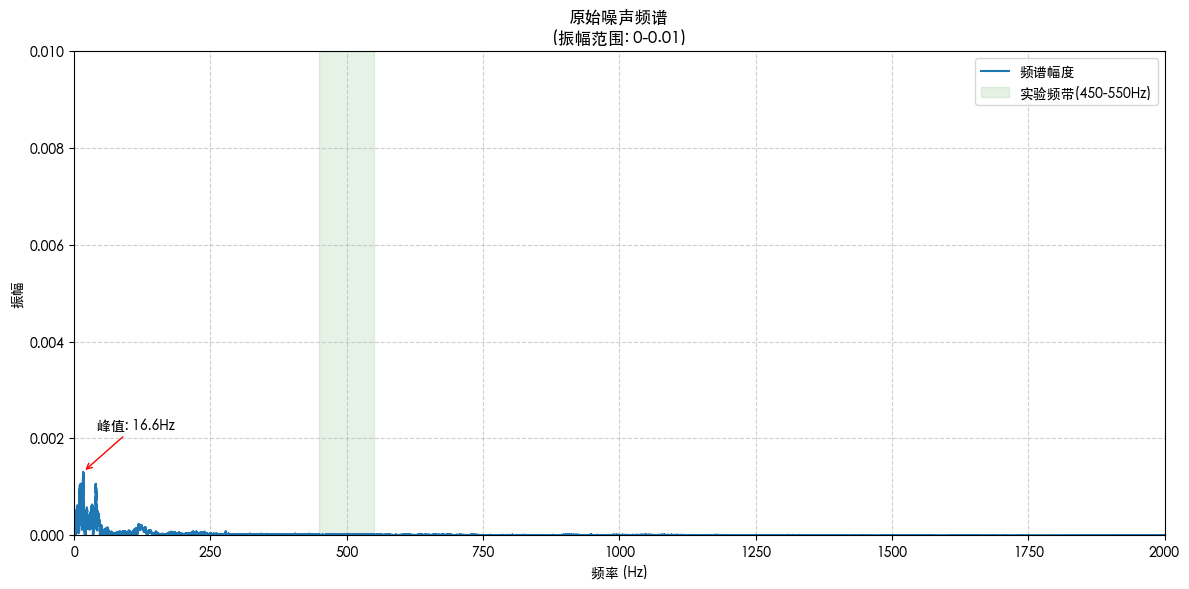


滤波后频谱分析:


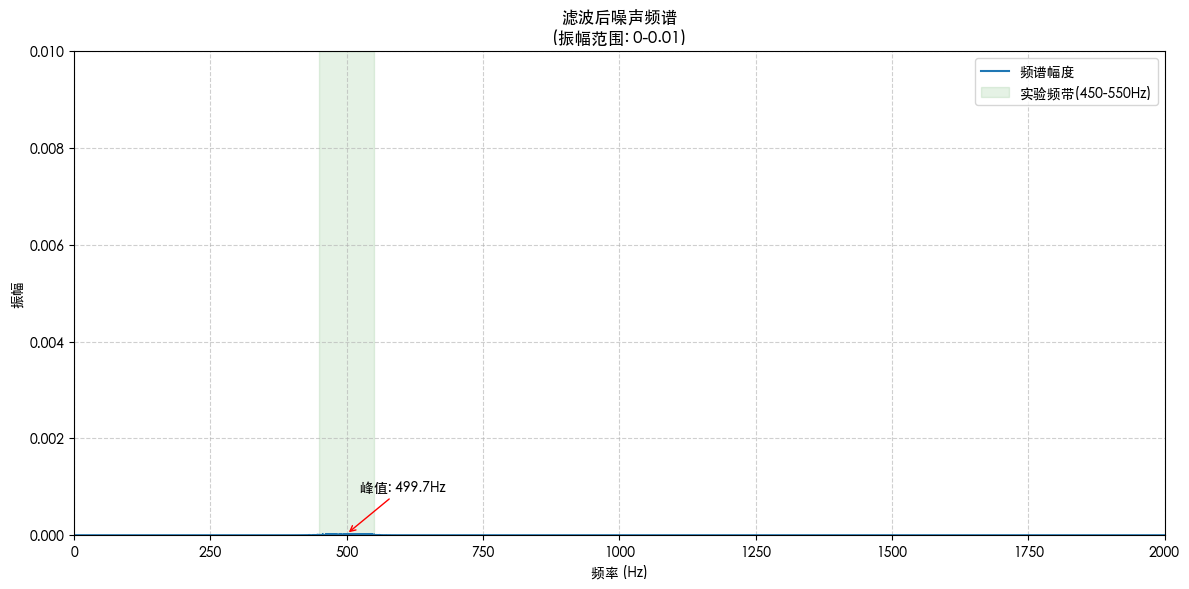


带外噪声抑制比: 24.3 dB


In [ ]:
import os
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from scipy.fft import fft, fftfreq

def plot_unified_spectrum(waveform, sample_rate, title="频谱分析", ylim_max=0.01):
    """
    绘制频谱图

    """
    # 计算FFT
    N = waveform.shape[1]
    y = waveform.numpy()[0] if waveform.dim() > 1 else waveform.numpy()
    yf = fft(y)
    xf = fftfreq(N, 1/sample_rate)[:N//2]
    magnitude = np.abs(yf[:N//2]) / N
    magnitude[1:] *= 2  
    
    # 创建图形
    plt.figure(figsize=(12, 6))
    
    # 绘制频谱
    plt.plot(xf, magnitude, 
            color='#1f77b4', 
            linewidth=1.5,
            label='频谱幅度')
    
    # 标记实验频带
    plt.axvspan(450, 550, color='green', alpha=0.1, label='实验频带(450-550Hz)')
    
    # 标记最大峰值
    peak_idx = np.argmax(magnitude)
    plt.annotate(f'峰值: {xf[peak_idx]:.1f}Hz', 
                xy=(xf[peak_idx], magnitude[peak_idx]),
                xytext=(10, 30),
                textcoords='offset points',
                arrowprops=dict(arrowstyle="->", color='red'))
    
    # 统一坐标设置
    plt.ylim(0, ylim_max)
    plt.xlim(0, 2000)
    plt.title(f"{title}\n(振幅范围: 0-{ylim_max})")
    plt.xlabel("频率 (Hz)")
    plt.ylabel("振幅")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return magnitude

def analyze_noise_file(filepath, ylim_max=0.01):
    """完整的底噪分析流程"""
    try:
        # 1. 加载文件
        waveform, sr = torchaudio.load(filepath)
        waveform = waveform.mean(dim=0, keepdim=True)
        print(f"文件加载成功 - 时长: {waveform.shape[1]/sr:.2f}秒")
        
        # 2. 绘制原始频谱
        print("\n原始频谱分析:")
        orig_mag = plot_unified_spectrum(waveform, sr, "原始噪声频谱", ylim_max)
        
        # 3. 设计滤波器
        b, a = butter(5, [450, 550], btype='bandpass', fs=sr)
        
        # 4. 应用滤波器
        filtered = lfilter(b, a, waveform.numpy()[0])
        filtered_wave = torch.from_numpy(filtered).float().unsqueeze(0)
        
        # 5. 绘制滤波后频谱
        print("\n滤波后频谱分析:")
        filt_mag = plot_unified_spectrum(filtered_wave, sr, "滤波后噪声频谱", ylim_max)
        
        # 6. 计算带外噪声抑制比
        def band_energy(mag, band):
            low = int(band[0] * len(mag) / (sr/2))
            high = int(band[1] * len(mag) / (sr/2))
            return np.mean(mag[low:high])
        
        orig_out = (band_energy(orig_mag, [0,450]) + band_energy(orig_mag, [550,2000]))/2
        filt_out = (band_energy(filt_mag, [0,450]) + band_energy(filt_mag, [550,2000]))/2
        rejection = 10 * np.log10(orig_out / (filt_out + 1e-10))
        
        print(f"\n带外噪声抑制比: {rejection:.1f} dB")
        
    except Exception as e:
        print(f"分析失败: {str(e)}")

# 使用示例
if __name__ == "__main__":
    noise_file = "background/37-rotation.wav"  
    
    if os.path.exists(noise_file):
        analyze_noise_file(noise_file, ylim_max=0.01)
    else:
        print(f"文件不存在: {noise_file}")

接下来对所有72个音频样本进行批量的处理。裁剪前后5秒后再与最短的音频样本对齐，并进行滤波。

In [ ]:
import os
import torch
import torchaudio
import numpy as np
from scipy.signal import butter, lfilter
from tqdm import tqdm 

class AudioBatchProcessor:
    def __init__(self, input_dir="data", output_dir="processed_data", 
                 sample_rate=16000, lowcut=450, highcut=550):
        """
        初始化批量处理器
        
        参数:
            input_dir: 输入数据目录 (包含类别子文件夹)
            output_dir: 处理后的输出目录
            sample_rate: 目标采样率
            lowcut: 带通滤波器低频截止
            highcut: 带通滤波器高频截止
        """
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.sample_rate = sample_rate
        self.lowcut = lowcut
        self.highcut = highcut
        self.b, self.a = self._design_filter()
        self.min_length = None  # 存储最短音频长度
        
        # 创建输出目录结构
        self._setup_output_dirs()
    
    def _design_filter(self):
        """设计带通滤波器"""
        nyq = 0.5 * self.sample_rate
        low = self.lowcut / nyq
        high = self.highcut / nyq
        b, a = butter(5, [low, high], btype='band')
        return b, a
    
    def _setup_output_dirs(self):
        """创建与输入相同的输出目录结构"""
        os.makedirs(self.output_dir, exist_ok=True)
        
        # 获取所有类别文件夹
        self.class_folders = []
        for item in os.listdir(self.input_dir):
            item_path = os.path.join(self.input_dir, item)
            if os.path.isdir(item_path):
                self.class_folders.append(item)
                os.makedirs(os.path.join(self.output_dir, item), exist_ok=True)
        
        print(f"发现 {len(self.class_folders)} 个类别文件夹: {self.class_folders}")
    
    def _find_min_length(self):
        """查找所有音频文件中最短的裁剪后长度"""
        print("\n正在计算最短音频长度...")
        min_length = float('inf')
        
        for class_folder in self.class_folders:
            input_folder = os.path.join(self.input_dir, class_folder)
            audio_files = [f for f in os.listdir(input_folder) if f.endswith('.wav')]
            
            for filename in tqdm(audio_files, desc=f"扫描 {class_folder}"):
                input_path = os.path.join(input_folder, filename)
                
                try:
                    waveform, sr = torchaudio.load(input_path)
                    if sr != self.sample_rate:
                        waveform = torchaudio.functional.resample(waveform, sr, self.sample_rate)
                    
                    # 计算裁剪后的长度
                    start_trim = int(5 * self.sample_rate)
                    end_trim = int(5 * self.sample_rate)
                    cropped_length = waveform.shape[1] - start_trim - end_trim
                    
                    if cropped_length > 0 and cropped_length < min_length:
                        min_length = cropped_length
                except Exception as e:
                    print(f"扫描文件 {input_path} 时出错: {str(e)}")
        
        if min_length == float('inf'):
            raise ValueError("未找到有效的音频文件或所有文件都过短")
        
        print(f"\n确定最短裁剪后音频长度: {min_length} 采样点 ({min_length/self.sample_rate:.2f} 秒)")
        return min_length
    
    def _process_single_file(self, input_path, output_path, target_length):
        """
        处理单个音频文件
        
        参数:
            input_path: 输入文件路径
            output_path: 输出文件路径
            target_length: 目标长度(采样点数)
        """
        try:
            # 1. 加载音频
            waveform, sr = torchaudio.load(input_path)

            
            # 2. 裁剪音频 (去除前5秒和后5秒)
            start_trim = int(5 * self.sample_rate)
            end_trim = int(5 * self.sample_rate)
            
            if waveform.shape[1] > start_trim + end_trim:
                waveform = waveform[:, start_trim:-end_trim]
            else:
                print(f"警告: 文件 {os.path.basename(input_path)} 过短，跳过裁剪")
                return False
            
            # 3. 统一长度 (截断)
            if waveform.shape[1] > target_length:
                waveform = waveform[:, :target_length]  # 截断
            elif waveform.shape[1] < target_length:
                # 填充静音
                padding = target_length - waveform.shape[1]
                waveform = torch.nn.functional.pad(waveform, (0, padding))
            
            # 4. 应用带通滤波
            if waveform.dim() > 1:
                waveform = waveform.mean(dim=0)  # 确保单通道
            
            filtered = lfilter(self.b, self.a, waveform.numpy())
            filtered = torch.from_numpy(filtered).float().unsqueeze(0)
            
            # 5. 保存处理后的文件
            torchaudio.save(output_path, filtered, self.sample_rate)
            
            return True
        except Exception as e:
            print(f"处理文件 {input_path} 时出错: {str(e)}")
            return False
    
    def process_all(self):
        """
        批量处理所有音频文件
        
        返回:
            processed_count: 成功处理的文件数
            error_count: 处理失败的文件数
        """
        # 首先确定最短长度
        self.min_length = self._find_min_length()
        
        processed_count = 0
        error_count = 0
        
        print(f"\n开始批量处理 {self.input_dir} 中的音频文件...")
        
        for class_folder in self.class_folders:
            input_folder = os.path.join(self.input_dir, class_folder)
            output_folder = os.path.join(self.output_dir, class_folder)
            
            # 获取所有.wav文件
            audio_files = [f for f in os.listdir(input_folder) if f.endswith('.wav')]
            print(f"\n处理类别 {class_folder} ({len(audio_files)} 个文件)")
            
            # 使用进度条
            for filename in tqdm(audio_files, desc=f"处理 {class_folder}"):
                input_path = os.path.join(input_folder, filename)
                output_path = os.path.join(output_folder, filename)
                
                if self._process_single_file(input_path, output_path, self.min_length):
                    processed_count += 1
                else:
                    error_count += 1
        
        print(f"\n处理完成! 成功: {processed_count}, 失败: {error_count}")
        print(f"所有音频已统一长度为: {self.min_length} 采样点 ({self.min_length/self.sample_rate:.2f} 秒)")
        return processed_count, error_count


if __name__ == "__main__":
    # 初始化处理器
    processor = AudioBatchProcessor(
        input_dir="data1-4",
        output_dir="processed_data",
        sample_rate=16000,
        lowcut=450,
        highcut=550
    )
    
    # 执行批量处理
    processor.process_all()
    
    print("\n处理后的文件结构:")
    print(f"processed_data/")
    for folder in processor.class_folders:
        print(f"├── {folder}/")
        # 打印前几个文件作为示例
        sample_files = os.listdir(os.path.join("processed_data", folder))[:3]
        for file in sample_files:
            print(f"│   ├── {file}")
        if len(sample_files) < len(os.listdir(os.path.join("processed_data", folder))):
            print(f"│   └── ... (共 {len(os.listdir(os.path.join('processed_data', folder)))} 个文件)")

发现 2 个类别文件夹: ['1', '4']

正在计算最短音频长度...


扫描 4: 100%|██████████| 36/36 [00:00<00:00, 625.23it/s]



确定最短裁剪后音频长度: 325888 采样点 (20.37 秒)

开始批量处理 data1-4 中的音频文件...

处理类别 1 (36 个文件)


处理 1: 100%|██████████| 36/36 [00:00<00:00, 256.75it/s]



处理类别 4 (36 个文件)


处理 4: 100%|██████████| 36/36 [00:00<00:00, 244.76it/s]


处理完成! 成功: 72, 失败: 0
所有音频已统一长度为: 325888 采样点 (20.37 秒)

处理后的文件结构:
processed_data/
├── 1/
│   ├── 02.wav
│   ├── 16.wav
│   ├── 17.wav
│   └── ... (共 37 个文件)
├── 4/
│   ├── REC_027.wav
│   ├── REC_033.wav
│   ├── REC_032.wav
│   └── ... (共 36 个文件)
